In [1]:
import numpy as np
import torch

from dataset import Cifar100

from random import choice

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import top_k_accuracy_score

from collections import Counter

In [2]:
model = torch.load('ae250.model').encoder.cuda()
class_model = torch.load('classification310.model').cuda()

model.eval()
class_model.eval()

ClassificationModel(
  (conv_block): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(3, 3))
    (1): Dropout2d(p=0.3, inplace=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
  )
  (fc_block): Sequential(
    (0): Linear(in_features=1600, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=100, bias=True)
  )
  (final): LogSoftmax(dim=1)
)

In [3]:
test_data = Cifar100("CIFAR100/TEST")

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=len(test_data), num_workers=12
)

In [4]:
data, classes = next(iter(test_loader))

In [5]:
data = data.cuda()
data = data.to(torch.float32)
data /= 255
classes = classes.numpy()

top 3, top 5 and top 10 score

In [6]:
predict = class_model(model(data)).detach().cpu().numpy()
top_k_accuracy_score(classes, predict, k=3), top_k_accuracy_score(classes, predict, k=5), top_k_accuracy_score(classes, predict, k=10)

(0.2429, 0.3141, 0.4395)

In [7]:
error_per_class = Counter()

for i in range(len(test_data.classes)):
    error_per_class[i] += sum((predict.argmax(1) == classes)[classes == i]).item()


In [8]:
count_classes = 10
each_classes_count = 100 
displayed_classes = [test_data.classes[x[0]] for x in error_per_class.most_common()[:count_classes]]
displayed_classes

['sea',
 'wardrobe',
 'cockroach',
 'maple_tree',
 'aquarium_fish',
 'cloud',
 'apple',
 'road',
 'oak_tree',
 'lawn_mower']

In [9]:
id_disp_classes = [test_data.classes.index(x) for x in displayed_classes]

new_data = data[classes == id_disp_classes[0]][:each_classes_count]

for i in id_disp_classes[1:]:
    new_data = torch.cat((new_data, data[classes == i][:each_classes_count]))

data = new_data
data.shape

torch.Size([1000, 3, 32, 32])

In [10]:
data = model(data)

In [11]:
data = class_model.conv_block(data)
data = data.reshape(-1, 1600)
data = class_model.fc_block(data)
data.shape

torch.Size([1000, 100])

In [12]:
data = data.detach().cpu().numpy()

In [13]:
data.shape

(1000, 100)

In [14]:
pca = PCA(n_components=2)
pca.fit_transform(data)
x = pca.transform(data)

two-dimensional representation of elements

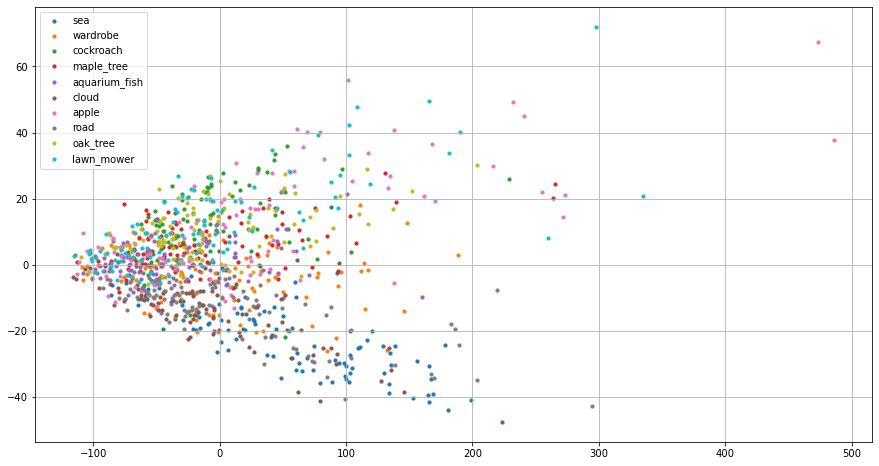

In [15]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot() 

for i, id in enumerate(id_disp_classes):
    j = x[i * each_classes_count: (i + 1) * each_classes_count]
    ax.scatter(j[:, 0], j[:, 1], s=10)

ax.legend(displayed_classes)

ax.grid()